<a href="https://colab.research.google.com/github/Sonaljothylingam/Seed-Identification/blob/main/MP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.3 MB/s eta 0:00:00


In [ ]:
import os

# Define the path to your dataset folder
dataset_path = '/content/drive/MyDrive/Seeds'

# Check the contents of the folder
os.chdir(dataset_path)


In [ ]:
from skimage.feature import canny
from skimage.feature import daisy
from sklearn_extra.cluster import KMedoids
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import cv2
import numpy as np
from skimage import exposure
from skimage.filters import gabor
from skimage.feature import local_binary_pattern
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import hog
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Function to extract color histograms
def extract_color_histogram(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    return hist_hue.flatten(), hist_saturation.flatten(), hist_value.flatten()

In [ ]:
# Function to extract Gabor filter features
def extract_gabor_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gabor_result, _ = gabor(gray_image, frequency=0.6, theta=1.5)
    return gabor_result.flatten()


# Function to extract GLCM (Gray Level Co-occurrence Matrix) features
def extract_glcm_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = greycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')
    dissimilarity = greycoprops(glcm, 'dissimilarity')
    homogeneity = greycoprops(glcm, 'homogeneity')
    energy = greycoprops(glcm, 'energy')
    correlation = greycoprops(glcm, 'correlation')
    glcm_features = np.hstack((contrast.flatten(), dissimilarity.flatten(), homogeneity.flatten(), energy.flatten(), correlation.flatten()))
    return glcm_features

In [ ]:
# Function to extract HOG (Histogram of Oriented Gradients) features using skimage
def extract_skimage_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features.flatten()


# Function to extract Local Binary Pattern (LBP) features using skimage
def extract_skimage_lbp_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    return hist.flatten()



In [ ]:
# Function to extract Canny edge features
def extract_canny_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = canny(gray_image)
    return edges.flatten()


# Function to extract DAISY (Descrete Anisotropic Scale Space) features
# def extract_daisy_features(image):
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     features = daisy(gray_image, step=180, radius=58, rings=2, histograms=6, orientations=8)
#     return features.flatten()


In [ ]:
# Function to extract texture features using Haralick features
def extract_haralick_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    textures = cv2.imgproc.textureFast(gray_image)
    # Extract Haralick texture features
    haralick = cv2.imgproc.haralick(textures)
    features = np.ravel(haralick)
    return features


# Function to perform advanced image processing
def advanced_image_processing(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized_image = exposure.equalize_hist(gray_image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)
    bilateral_filtered = cv2.bilateralFilter(image, 9, 75, 75)
    return equalized_image, clahe_image, bilateral_filtered

In [ ]:
def extract_features_and_clustering(dataset_path):
    images = []
    min_height = 100
    min_width = 100

    for subdir, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            img = cv2.imread(file_path)
            if img.shape[0] >= min_height and img.shape[1] >= min_width:
                images.append(img)
            else:
                print(f"Ignoring {file_path} due to small dimensions.")

    color_histograms = []
    gabor_features_list = []
    glcm_features_list = []
    skimage_hog_features_list = []
    skimage_lbp_features_list = []
    canny_features_list = []
    haralick_features_list = []

    for img in images:
        hist_hue, hist_saturation, hist_value = extract_color_histogram(img)
        color_histograms.append(np.concatenate([hist_hue, hist_saturation, hist_value]))

        gabor_features = extract_gabor_features(img)
        gabor_features_list.append(gabor_features)

        glcm_features = extract_glcm_features(img)
        glcm_features_list.append(glcm_features)

        skimage_hog_features = extract_skimage_hog_features(img)
        skimage_hog_features_list.append(skimage_hog_features)

        skimage_lbp_features = extract_skimage_lbp_features(img)
        skimage_lbp_features_list.append(skimage_lbp_features)

        canny_features = extract_canny_features(img)
        canny_features_list.append(canny_features)


    # Truncate or pad lists to ensure equal lengths
    # Ensure equal lengths of lists
    min_length = min(len(color_histograms), len(gabor_features_list), len(glcm_features_list),
                     len(skimage_hog_features_list), len(skimage_lbp_features_list), len(canny_features_list))

    color_histograms = [feature[:min_length] for feature in color_histograms]
    gabor_features_list = [feature[:min_length] for feature in gabor_features_list]
    glcm_features_list = [feature[:min_length] for feature in glcm_features_list]
    skimage_hog_features_list = [feature[:min_length] for feature in skimage_hog_features_list]
    skimage_lbp_features_list = [feature[:min_length] for feature in skimage_lbp_features_list]
    canny_features_list = [feature[:min_length] for feature in canny_features_list]


    # Concatenate the features
    features = np.concatenate([color_histograms, gabor_features_list, glcm_features_list,
                               skimage_hog_features_list, skimage_lbp_features_list, canny_features_list], axis=1)

    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    k = 5
    kmedoids = KMedoids(n_clusters=k)
    clusters = kmedoids.fit_predict(features_scaled)

    return features_scaled, clusters


In [ ]:
def encode_features(features):
    from sklearn.decomposition import PCA

    # Determine the maximum value for n_components based on the minimum of samples or features
    n_components = min(features.shape[0], features.shape[1])

    # Reduce n_components to avoid exceeding the minimum of samples or features
    n_components = min(n_components, 90)  # Set a maximum value of 90 for n_components

    pca = PCA(n_components=n_components)
    encoded_features = pca.fit_transform(features)
    return encoded_features



# # Function to perform Decision Tree Classification
# def decision_tree_classification(encoded_features, clusters):
#     X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)
#     tree_classifier = DecisionTreeClassifier(random_state=42)
#     tree_classifier.fit(X_train, y_train)
#     y_pred = tree_classifier.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     return accuracy




In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Decision Tree Classifier')
    plt.legend()
    plt.show()

# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

# Function to perform Decision Tree Classification and get metrics
def decision_tree_classification_metrics(encoded_features, clusters):
    X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)
    tree_classifier = DecisionTreeClassifier(random_state=42)
    tree_classifier.fit(X_train, y_train)
    y_pred = tree_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate ROC AUC score
    y_pred_proba = tree_classifier.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba)

    # Display confusion matrix
    display_confusion_matrix(y_test, y_pred)

    return accuracy, roc_auc



In [ ]:
# Define the path to your dataset folder
dataset_path = '/content/drive/MyDrive/Seeds'

# Extract features and perform clustering
features_scaled, clusters = extract_features_and_clustering(dataset_path)



Ignoring /content/drive/MyDrive/Seeds/Litchi/Litchi (59).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Orange/Orange (82).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Sapodilla/Sapodilla (45).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Hog_Plum/Hog_Plum (63).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Hog_Plum/Hog_Plum (66).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Hog_Plum/Hog_Plum (64).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Hog_Plum/Hog_Plum (65).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Olive/Olive (76).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Olive/Olive (75).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Amla/Amla (24).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Amla/Amla (27).jpg due to small dimensions.
Ignoring /content/drive/MyDrive/Seeds/Amla/A

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

In [ ]:
# Encode features
encoded_features = encode_features(features_scaled)


In [ ]:

# # Perform Decision Tree Classification
# accuracy = decision_tree_classification(encoded_features, clusters)
# print("Accuracy of Decision Tree Classifier using K-medoids clusters:", accuracy)

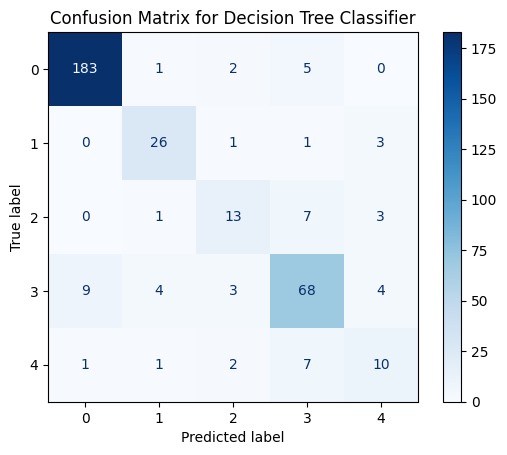

Accuracy of Decision Tree Classifier using K-medoids clusters: 0.8450704225352113


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def decision_tree_classification_metrics(encoded_features, clusters):
    X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)
    tree_classifier = DecisionTreeClassifier(random_state=42)
    tree_classifier.fit(X_train, y_train)
    y_pred = tree_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix for Decision Tree Classifier')
    plt.show()

    return accuracy

# Perform Decision Tree Classification and plot confusion matrix
dec_accuracy = decision_tree_classification_metrics(encoded_features, clusters)
print("Accuracy of Decision Tree Classifier using K-medoids clusters:", dec_accuracy)


In [ ]:
from sklearn.svm import SVC

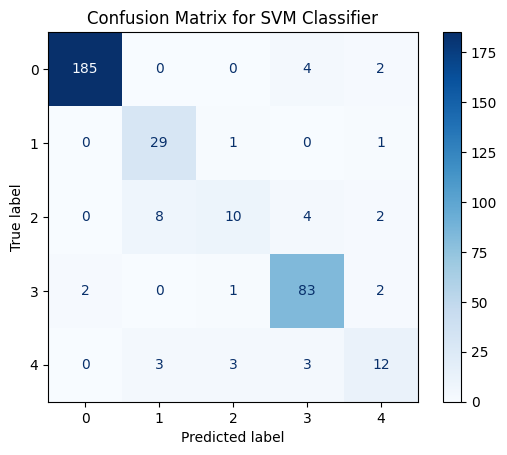

Accuracy of SVM Classifier using K-medoids clusters: 0.8985915492957747


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def svm_classification_metrics(encoded_features, clusters):
    X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)
    svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix for SVM Classifier')
    plt.show()

    return accuracy

# Perform SVM Classification and plot confusion matrix
svm_accuracy = svm_classification_metrics(encoded_features, clusters)
print("Accuracy of SVM Classifier using K-medoids clusters:", svm_accuracy)


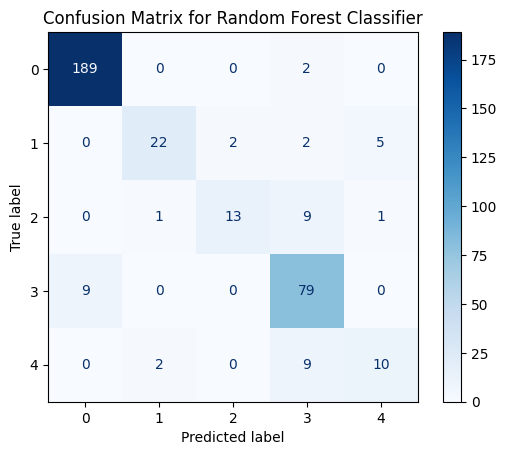

Accuracy of Random Forest Classifier using K-medoids clusters: 0.8816901408450705


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Function to perform Random Forest Classification
def random_forest_classification_metrics(encoded_features, clusters):
    X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)
    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix for Random Forest Classifier')
    plt.show()

    return accuracy

# Perform Random Forest Classification and plot confusion matrix
rf_accuracy = random_forest_classification_metrics(encoded_features, clusters)
print("Accuracy of Random Forest Classifier using K-medoids clusters:", rf_accuracy)





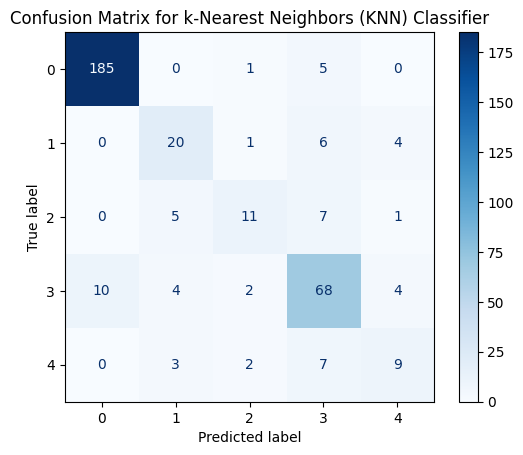

Accuracy of k-Nearest Neighbors (KNN) Classifier using K-medoids clusters: 0.8253521126760563


In [ ]:
# Function to perform k-Nearest Neighbors (KNN) Classification
def knn_classification_metrics(encoded_features, clusters):
    X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)
    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix for k-Nearest Neighbors (KNN) Classifier')
    plt.show()

    return accuracy

# Perform k-Nearest Neighbors (KNN) Classification and plot confusion matrix
knn_accuracy = knn_classification_metrics(encoded_features, clusters)
print("Accuracy of k-Nearest Neighbors (KNN) Classifier using K-medoids clusters:", knn_accuracy)

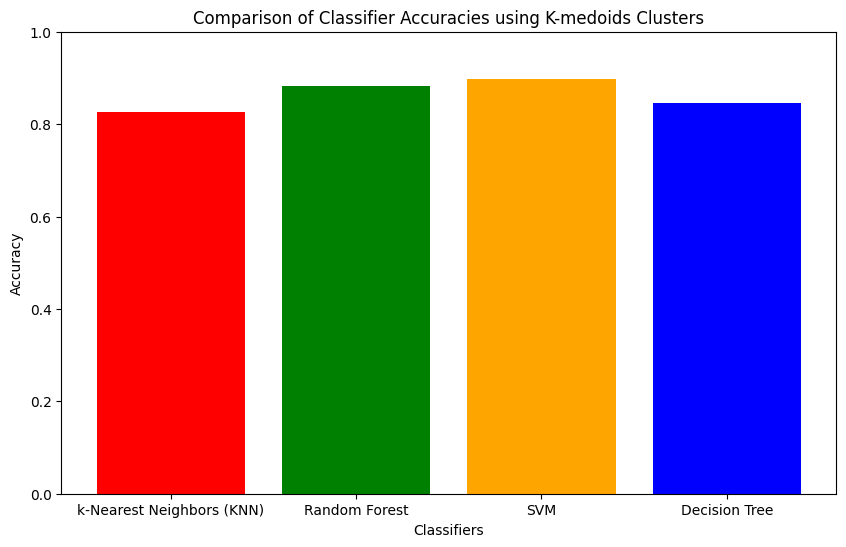

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values
accuracies = [knn_accuracy, rf_accuracy, svm_accuracy,dec_accuracy]

# Classifier names
classifiers = ['k-Nearest Neighbors (KNN)', 'Random Forest', 'SVM','Decision Tree']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracies, color=['red', 'green', 'orange','blue'])
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies using K-medoids Clusters')
plt.ylim(0, 1)  # Setting y-axis limit to better visualize differences
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve

def calculate_metrics(y_test, y_pred, y_pred_proba):
    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')

    # F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')



    return precision, recall, f1

def decision_tree_classification_metrics(encoded_features, clusters):
    X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)
    tree_classifier = DecisionTreeClassifier(random_state=42)
    tree_classifier.fit(X_train, y_train)
    y_pred = tree_classifier.predict(X_test)


    # Calculate probabilities for positive class
    y_pred_proba = tree_classifier.predict_proba(X_test)

    # Calculate additional metrics
    precision, recall, f1 = calculate_metrics(y_test, y_pred, y_pred_proba)


    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


decision_tree_classification_metrics(encoded_features, clusters)



Precision: 0.8419296118996915
Recall: 0.8450704225352113
F1 Score: 0.8432251946639185


In [ ]:
def svm_classification_metrics(encoded_features, clusters):
    X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)
    svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)

    # # Calculate probabilities for positive class
    y_pred_proba = svm_classifier.predict_proba(X_test)

    # Calculate additional metrics
    precision, recall, f1 = calculate_metrics(y_test, y_pred, y_pred_proba)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


# Perform SVM Classification and compute all metrics
svm_classification_metrics(encoded_features, clusters)



Precision: 0.8968943797342201
Recall: 0.8985915492957747
F1 Score: 0.8942339272987956


In [ ]:
def random_forest_classification_metrics(encoded_features, clusters):
    X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)
    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)

    # Calculate probabilities for positive class
    y_pred_proba = rf_classifier.predict_proba(X_test)

    # Calculate additional metrics
    precision, recall, f1 = calculate_metrics(y_test, y_pred, y_pred_proba)


    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


random_forest_classification_metrics(encoded_features, clusters)


Precision: 0.8798728591168977
Recall: 0.8816901408450705
F1 Score: 0.8757002915408361


In [ ]:
def knn_classification_metrics(encoded_features, clusters):
    X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)
    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)


    # Calculate probabilities for positive class
    y_pred_proba = knn_classifier.predict_proba(X_test)

    # Calculate additional metrics
    precision, recall, f1= calculate_metrics(y_test, y_pred, y_pred_proba)


    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


knn_classification_metrics(encoded_features, clusters)

Precision: 0.8195876788488435
Recall: 0.8253521126760563
F1 Score: 0.8210066047072261


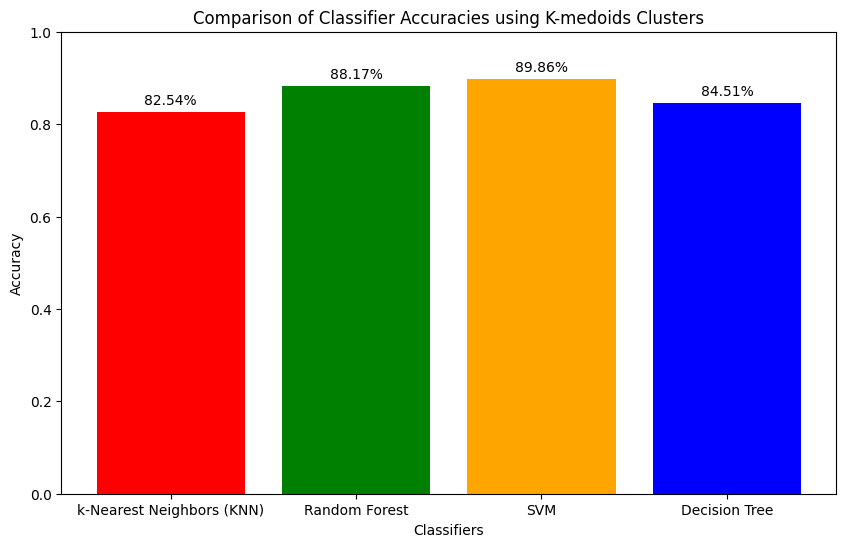

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values
accuracies = [knn_accuracy, rf_accuracy, svm_accuracy, dec_accuracy]

# Classifier names
classifiers = ['k-Nearest Neighbors (KNN)', 'Random Forest', 'SVM', 'Decision Tree']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color=['red', 'green', 'orange', 'blue'])
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies using K-medoids Clusters')
plt.ylim(0, 1)  # Setting y-axis limit to better visualize differences

# Adding text annotations on top of each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{accuracy:.2%}', ha='center', va='bottom')

plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)



Accuracy: 0.8816901408450705
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       191
           1       0.88      0.71      0.79        31
           2       0.87      0.54      0.67        24
           3       0.78      0.90      0.84        88
           4       0.62      0.48      0.54        21

    accuracy                           0.88       355
   macro avg       0.82      0.72      0.76       355
weighted avg       0.88      0.88      0.88       355

Confusion Matrix:
[[189   0   0   2   0]
 [  0  22   2   2   5]
 [  0   1  13   9   1]
 [  9   0   0  79   0]
 [  0   2   0   9  10]]


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)

# Define individual classifiers
svm_classifier = SVC(probability=True)
rf_classifier = RandomForestClassifier()
knn_classifier = KNeighborsClassifier()

# Define the ensemble model using voting
voting_classifier = VotingClassifier(estimators=[('svm', svm_classifier), ('rf', rf_classifier), ('knn', knn_classifier)], voting='soft')

# Train the ensemble model
voting_classifier.fit(X_train, y_train)

# Predict the labels
y_pred = voting_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate ROC AUC score
y_pred_proba = voting_classifier.predict_proba(X_test)


# Display confusion matrix and ROC curve
display_confusion_matrix(y_test, y_pred)

# Print accuracy and ROC AUC score
print("Accuracy:", accuracy)



Confusion Matrix:
[[189   0   0   2   0]
 [  0  19   1   5   6]
 [  0   5   9   9   1]
 [  8   3   2  74   1]
 [  0   4   1   7   9]]
Accuracy: 0.8450704225352113


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)

# Initialize Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the classifier
gb_classifier.fit(X_train, y_train)

# Predict the labels for test set
y_pred = gb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



# Display confusion matrix
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

# Display confusion matrix
display_confusion_matrix(y_test, y_pred)


Accuracy: 0.9126760563380282
Confusion Matrix:
[[189   0   0   2   0]
 [  0  26   0   0   5]
 [  0   1  16   7   0]
 [  8   0   0  80   0]
 [  0   1   0   7  13]]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train the classifier
adaboost_classifier.fit(X_train, y_train)

# Predict the labels for test set
y_pred = adaboost_classifier.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate accuracy
accuracy_adaboost = accuracy_score(y_test, y_pred)
print("AdaBoost Accuracy:", accuracy_adaboost)

# Compute confusion matrix
conf_matrix_adaboost = confusion_matrix(y_test, y_pred)
print("AdaBoost Confusion Matrix:")
print(conf_matrix_adaboost)


AdaBoost Accuracy: 0.6
AdaBoost Confusion Matrix:
[[125   0   0  66   0]
 [  0   3   9  19   0]
 [  0   0  17   6   1]
 [  1   1  19  66   1]
 [  0   2   8   9   2]]


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_features, clusters, test_size=0.2, random_state=42)

# Initialize Bagging classifier without specifying base_estimator
bagging_classifier = BaggingClassifier(n_estimators=100, random_state=42)

# Train the classifier
bagging_classifier.fit(X_train, y_train)

# Predict the labels for test set
y_pred = bagging_classifier.predict(X_test)

# Calculate accuracy
accuracy_bagging = accuracy_score(y_test, y_pred)
print("Bagging Accuracy:", accuracy_bagging)

# Compute confusion matrix
conf_matrix_bagging = confusion_matrix(y_test, y_pred)
print("Bagging Confusion Matrix:")
print(conf_matrix_bagging)


Bagging Accuracy: 0.8901408450704226
Bagging Confusion Matrix:
[[184   0   0   7   0]
 [  0  26   0   0   5]
 [  0   2  14   7   1]
 [  8   0   0  80   0]
 [  0   2   0   7  12]]


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize Extra Trees classifier
extra_trees_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Train the classifier
extra_trees_classifier.fit(X_train, y_train)

# Predict the labels for test set
y_pred = extra_trees_classifier.predict(X_test)
# Calculate accuracy
accuracy_extra_trees = accuracy_score(y_test, y_pred)
print("Extra Trees Accuracy:", accuracy_extra_trees)

# Compute confusion matrix
conf_matrix_extra_trees = confusion_matrix(y_test, y_pred)
print("Extra Trees Confusion Matrix:")
print(conf_matrix_extra_trees)


Extra Trees Accuracy: 0.8422535211267606
Extra Trees Confusion Matrix:
[[188   0   0   3   0]
 [  0  23   0   3   5]
 [  1   2  11   8   2]
 [ 19   0   0  69   0]
 [  1   2   0  10   8]]


In [ ]:
import lightgbm as lgb

# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test)

# Define parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

# Train the model
lgb_classifier = lgb.train(params, train_data, num_boost_round=100)

# Predict probabilities for test set
y_pred_proba = lgb_classifier.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)


In [ ]:
# Calculate accuracy
accuracy_lightgbm = accuracy_score(y_test, y_pred)
print("LightGBM Accuracy:", accuracy_lightgbm)

# Compute confusion matrix
conf_matrix_lightgbm = confusion_matrix(y_test, y_pred)
print("LightGBM Confusion Matrix:")
print(conf_matrix_lightgbm)


LightGBM Accuracy: 0.6197183098591549
LightGBM Confusion Matrix:
[[189   2   0   0   0]
 [  0  31   0   0   0]
 [  0  24   0   0   0]
 [  6  82   0   0   0]
 [  0  21   0   0   0]]


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 939.7 kB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

# Initialize CatBoost classifier
catboost_classifier = CatBoostClassifier(iterations=100, random_seed=42)

# Train the classifier
catboost_classifier.fit(X_train, y_train)

# Predict the labels for test set
y_pred = catboost_classifier.predict(X_test)


Learning rate set to 0.5
0:	learn: 0.9392241	total: 175ms	remaining: 17.3s
1:	learn: 0.7309676	total: 258ms	remaining: 12.6s
2:	learn: 0.5913617	total: 347ms	remaining: 11.2s
3:	learn: 0.4923682	total: 448ms	remaining: 10.8s
4:	learn: 0.4115091	total: 533ms	remaining: 10.1s
5:	learn: 0.3726167	total: 618ms	remaining: 9.68s
6:	learn: 0.3343742	total: 711ms	remaining: 9.44s
7:	learn: 0.3118489	total: 795ms	remaining: 9.15s
8:	learn: 0.2865433	total: 886ms	remaining: 8.96s
9:	learn: 0.2742038	total: 974ms	remaining: 8.76s
10:	learn: 0.2576632	total: 1.06s	remaining: 8.57s
11:	learn: 0.2501618	total: 1.22s	remaining: 8.97s
12:	learn: 0.2389697	total: 1.45s	remaining: 9.7s
13:	learn: 0.2266290	total: 1.68s	remaining: 10.3s
14:	learn: 0.2102487	total: 1.95s	remaining: 11.1s
15:	learn: 0.1988558	total: 2.05s	remaining: 10.8s
16:	learn: 0.1885577	total: 2.14s	remaining: 10.4s
17:	learn: 0.1772740	total: 2.23s	remaining: 10.1s
18:	learn: 0.1638764	total: 2.31s	remaining: 9.84s
19:	learn: 0.1545

In [ ]:
# Calculate accuracy
accuracy_catboost = accuracy_score(y_test, y_pred)
print("CatBoost Accuracy:", accuracy_catboost)

# Compute confusion matrix
conf_matrix_catboost = confusion_matrix(y_test, y_pred)
print("CatBoost Confusion Matrix:")
print(conf_matrix_catboost)


CatBoost Accuracy: 0.8873239436619719
CatBoost Confusion Matrix:
[[187   0   0   4   0]
 [  0  26   0   0   5]
 [  0   4  12   8   0]
 [  9   0   0  78   1]
 [  0   3   1   5  12]]


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Initialize base classifiers
classifier1 = LogisticRegression()
classifier2 = DecisionTreeClassifier()
classifier3 = SVC()

# Define the voting classifier
voting_classifier = VotingClassifier(estimators=[('lr', classifier1), ('dt', classifier2), ('svc', classifier3)], voting='hard')

# Train the voting classifier
voting_classifier.fit(X_train, y_train)

# Predict the labels for test set
y_pred = voting_classifier.predict(X_test)

# Calculate accuracy
accuracy_voting = accuracy_score(y_test, y_pred)
print("Voting Classifier Accuracy:", accuracy_voting)

# Compute confusion matrix
conf_matrix_voting = confusion_matrix(y_test, y_pred)
print("Voting Classifier Confusion Matrix:")
print(conf_matrix_voting)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier Accuracy: 0.8760563380281691
Voting Classifier Confusion Matrix:
[[189   1   0   1   0]
 [  0  29   0   1   1]
 [  0  10   6   8   0]
 [  8   2   1  77   0]
 [  0   3   3   5  10]]


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Initialize base classifiers
classifier1 = LogisticRegression()
classifier2 = DecisionTreeClassifier()
classifier3 = SVC()

# Define the stacking classifier
estimators = [('lr', classifier1), ('dt', classifier2), ('svc', classifier3)]
meta_classifier = LogisticRegression()
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=meta_classifier)

# Train the stacking classifier
stacking_classifier.fit(X_train, y_train)

# Predict the labels for test set
y_pred = stacking_classifier.predict(X_test)

# Calculate accuracy
accuracy_stacking = accuracy_score(y_test, y_pred)
print("Stacking Classifier Accuracy:", accuracy_stacking)

# Compute confusion matrix
conf_matrix_stacking = confusion_matrix(y_test, y_pred)
print("Stacking Classifier Confusion Matrix:")
print(conf_matrix_stacking)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier Accuracy: 0.9267605633802817
Stacking Classifier Confusion Matrix:
[[189   1   0   1   0]
 [  0  28   1   0   2]
 [  0   1  18   3   2]
 [  4   0   2  82   0]
 [  0   2   3   4  12]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
